## Predict Survival on The Titanic (Kaggle)
Two step prediction
1. Predict Ages for Nan Values using XGBoost Regressor <br>
2. Predict Survival using XGBoost Classifier <br>

### Titanic Route

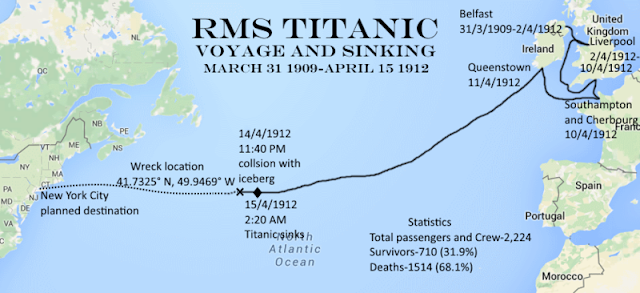

In [1]:
from IPython.core.display import Image
Image('./Titanic_Route.png')

### Import Libraries

In [2]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import IPython.display as display
from sklearn.preprocessing import LabelBinarizer,StandardScaler,LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor,XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from keras import layers,models,optimizers,regularizers

Using TensorFlow backend.


### Data Loading

In [3]:
path_home = os.getcwd()
path_train = path_home + '/Dataset/train.csv'
path_test = path_home + '/Dataset/test.csv'
path_gensub = path_home + '/Dataset/gender_submission.csv'

train = pd.read_csv(path_train)
test = pd.read_csv(path_test)
sub_sample = pd.read_csv(path_gensub)

In [4]:
display.display(train.tail(5))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### Feature Engineering

In [5]:
func_scaler_util = lambda method, data: method(data.reshape(-1,1)).flatten()

In [6]:
def feature_engineering(dataset):
    ''' Feature Engineering '''    
    dataset_prepro = dataset.copy()
        
    # Label Binarizer for gender class
    lb = LabelBinarizer()
    dataset_prepro['Sex'] = lb.fit_transform(dataset_prepro['Sex'].values)

    # Label Encoder for Categorical values for embarkation
    # S: Southampton in England, C: Cherbourg in France, Q: Queentown in Ireland
    le = LabelEncoder()
    le.fit(['S','C','Q','nan'])
    dataset_prepro['Embarked'] = le.transform(dataset_prepro['Embarked'].values)

    # Cabin Class
    le_cabin = LabelEncoder()
    le_cabin.fit(['N','A','B','C','D','E','F','G','T'])
    dataset_prepro['Cabin'] = le_cabin.transform(dataset_prepro['Cabin'].astype(str).str[0].values)
    
    # Titles
    dataset_prepro['Title'] = dataset_prepro.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    RareTitles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
    dataset_prepro['Title'] = dataset_prepro['Title'].replace(RareTitles,'Rare')
    dataset_prepro['Title'] = dataset_prepro['Title'].replace('Mlle', 'Miss')
    dataset_prepro['Title'] = dataset_prepro['Title'].replace('Ms', 'Miss')
    dataset_prepro['Title'] = dataset_prepro['Title'].replace('Mme', 'Mrs')
    title_mapping = {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
    dataset_prepro['Title'] = dataset_prepro['Title'].map(title_mapping)
    
    # Whether One is Alone
    dataset_prepro['FamilySize'] = dataset_prepro['SibSp'] + dataset_prepro['Parch'] + 1
    dataset_prepro['Family'] = 0
    dataset_prepro.loc[dataset_prepro['FamilySize'] > 1, 'Family'] = 1
    return dataset_prepro

### Create Training Dataset to Predict Ages for Nan Values

In [7]:
# Feature Engineering for Categorical values
dataset_pred_age = pd.concat([train,test],sort=True)
dataset_pred_age.drop(['Survived','Ticket'],axis=1,inplace=True)
dataset_pred_age.dropna(how='any',axis=0,inplace=True)
dataset_pred_age = feature_engineering(dataset_pred_age)
col_list = ['Sex','Age','Fare','Family','Embarked','Pclass','Cabin','Title']
train_pred_age = dataset_pred_age[col_list].values

# Standardize fare after logarithmic conversion
fare_log = np.log1p(train_pred_age[:,2])*50 # Convert Fare values in logarithm
scaler_fare = StandardScaler()
scaler_fare.fit(fare_log.reshape(-1,1))
train_pred_age[:,2] = func_scaler_util(scaler_fare.transform,fare_log)

# Split whole dataset (test & training) into training & validation for age prediction
idx_age_pred = [0,2,3,4,5,6,7]
x, y = train_pred_age[:,idx_age_pred], train_pred_age[:,1]
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.15,random_state=42)

In [8]:
display.display(dataset_pred_age.describe())

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Title,FamilySize,Family
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,36.825630,2.366667,1.159259,84.942193,0.477778,663.955556,1.174074,0.511111,0.507407,2.044444,1.985185,0.585185
std,15.569971,1.459108,0.983416,80.698651,0.788784,371.875891,0.490878,0.500805,0.643773,1.143052,1.137304,0.493605
min,0.920000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,25.000000,1.000000,0.000000,30.000000,0.000000,337.250000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,36.000000,2.000000,2.000000,60.587500,0.000000,661.500000,1.000000,1.000000,0.000000,2.000000,2.000000,1.000000
75%,48.000000,3.000000,2.000000,103.193750,1.000000,968.500000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000
max,80.000000,8.000000,2.000000,512.329200,4.000000,1306.000000,3.000000,1.000000,3.000000,5.000000,6.000000,1.000000


### Age Prediction for NaN values

In [9]:
def AxConfig(ax,prmax):
    ''' Configure Axis '''
    ax.set_xlim([prmax['xmin'],prmax['xmax']])
    ax.set_ylim([prmax['ymin'],prmax['ymax']])
    ax.set_xticks(np.arange(prmax['xmin'],prmax['xmax'] + 1e-6,prmax['xmajor']))
    ax.set_yticks(np.arange(prmax['ymin'],prmax['ymax'] + 1e-6,prmax['ymajor']))
    ax.set_xticks(np.arange(prmax['xmin'],prmax['xmax'] + 1e-6,prmax['xminor']),minor=True)
    ax.set_yticks(np.arange(prmax['ymin'],prmax['ymax'] + 1e-6,prmax['yminor']),minor=True)
    plt.grid(b=True,which='minor',color='w',linestyle='--',linewidth=0.2,zorder=-1)
    plt.grid(b=True,which='major',color='w',linestyle='-',linewidth=0.5,zorder=-1)
    ax.patch.set_facecolor('#B5B5B5')

In [10]:
def plot_age_pred(age_actual,age_pred):    
    fig, ax = plt.subplots(figsize=(6,6))
    plt.scatter(age_actual,age_pred,c='yellow',s=20,marker='*')
    prmax = {'xmin':0,'xmax':80,'xmajor':20,'xminor':10,
             'ymin':0,'ymax':80,'ymajor':20,'yminor':10}
    AxConfig(ax,prmax)
    r2 = r2_score(age_actual,age_pred)
    ax.text(5, 70, '$R^{%d}$'%2 +': ' + '{:.3f}'.format(r2), fontsize=12)    
    plt.ylabel('Prediction')
    plt.xlabel('Actual')
    plt.show()

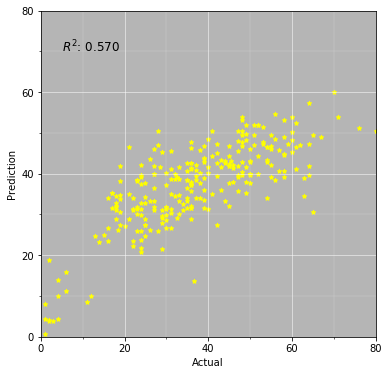

In [11]:
xgb_reg_age = XGBRegressor(objective='reg:squarederror')
xgb_reg_age.fit(x_train,y_train)
age_actual = train_pred_age[:,1]
age_pred = xgb_reg_age.predict(train_pred_age[:,idx_age_pred])
plot_age_pred(age_actual,age_pred)

In [12]:
def feature_importance(model,columns):
    ''' Feature Engineering '''
    importance = model.feature_importances_
    rankftr = np.argsort(importance)[::-1]
    importance = [importance[i] for i in rankftr]
    columns = [columns[i] for i in rankftr]
    for feature in zip(columns,importance):
        print(feature[0].ljust(9)+': '+'{:.2f}'.format(100*feature[1]).rjust(5)+'%')
    print('\n')

In [13]:
columns = [col_list[i] for i in idx_age_pred]
print('\nFeatures importance for age prediction')
feature_importance(xgb_reg_age,columns)


Features importance for age prediction
Pclass   : 44.32%
Title    : 16.40%
Family   : 12.50%
Cabin    : 10.36%
Fare     :  6.90%
Embarked :  5.48%
Sex      :  4.04%




### Preprocessing and Overview

In [14]:
def PreProcessing(dataset,col_list,xgb_reg_age,imp_median=None,training=True):
    dataset = dataset.copy()
    if training:
        target = np.array(dataset['Survived'])
        imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    else:
        target = None

    # Imputer for fare
    imp_median.fit(dataset[['Fare']])
    dataset['Fare'] = imp_median.transform(dataset[['Fare']])
    dataset['Fare'] = np.log1p(dataset['Fare'])*50
    dataset.loc[dataset['Embarked'].isnull(),'Embarked'] = 'nan'
    dataset.loc[dataset['Cabin'].isnull(),'Cabin'] = 'N'
    dataset['Fare'] = func_scaler_util(scaler_fare.transform,dataset['Fare'].values)
    
    feature = feature_engineering(dataset)[col_list].values

    # Predict age and scale it
    for i in range(len(feature)):
        feature_age = feature[i][idx_age_pred]
        feature[i,1] = xgb_reg_age.predict(np.reshape(feature_age,[1,7]))
    scaler_age = StandardScaler()
    scaler_age.fit(feature[:,1].reshape(-1,1))
    feature[:,1] = func_scaler_util(scaler_age.transform,feature[:,1])
    return feature,target,imp_median

In [15]:
feature_train,target_train,imp_median = PreProcessing(train,col_list,xgb_reg_age)

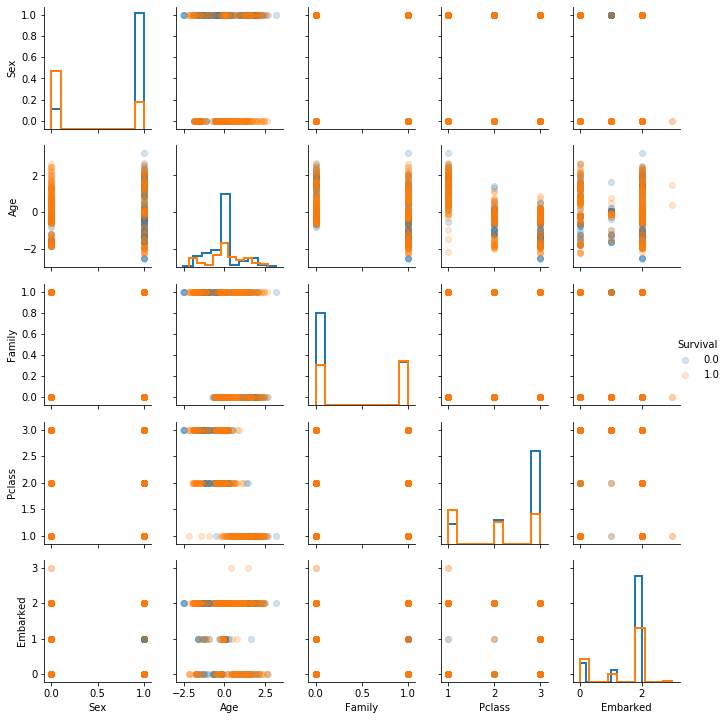

In [16]:
df_pair_plot = pd.DataFrame(np.vstack((feature_train.T,target_train)).T,columns=col_list+['Survival'])
g = sns.PairGrid(df_pair_plot, vars=['Sex','Age','Family','Pclass','Embarked'], hue='Survival')
g.map_diag(plt.hist, histtype='step', linewidth=2)
g.map_offdiag(plt.scatter, alpha=0.2)
g = g.add_legend()
g.fig.set_size_inches(10,10)
plt.show()

#### Insights
Sex, Title: More female passengers survived than male. <br>
Age: Thosed who didn't suvive aged at around the average. <br>
Family: Passengers with family likely survived. <br>
Pclass,Fare,Cabin: The higher the ticket class the more likely people survived. <br>
Embarked: People who embarked at Cherbourg in France more likely survived. <br>

In [17]:
df_pair_plot.describe()

,Sex,Age,Fare,Family,Embarked,Pclass,Cabin,Title,Survival
count,891.000000,8.910000e+02,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.647587,-1.847101e-16,-1.135509,0.397306,1.538721,2.308642,5.946128,1.728395,0.383838
std,0.477990,1.000562e+00,1.002317,0.489615,0.794231,0.836071,2.062347,1.030039,0.486592
min,0.000000,-2.532771e+00,-4.199453,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,-4.354854e-01,-1.937144,0.000000,1.000000,2.000000,7.000000,1.000000,0.000000
50%,1.000000,5.594664e-02,-1.367576,0.000000,2.000000,3.000000,7.000000,1.000000,0.000000
75%,1.000000,2.554337e-01,-0.614733,1.000000,2.000000,3.000000,7.000000,2.000000,1.000000
max,1.000000,3.203570e+00,2.255725,1.000000,3.000000,3.000000,8.000000,5.000000,1.000000


### Survival prediction for each passenger using XGBoost Classifier

In [18]:
xgb_cls = XGBClassifier(objective='reg:squarederror')
xgb_cls.fit(feature_train,target_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:squarederror', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
def result_summary(feature_train,target_train,model,columns):
    # Accuracy, Confusion Matrix, Classification Report
    pred_train = model.predict(feature_train)
    print('Accuracy: '+'{:.3f}'.format(accuracy_score(target_train,pred_train)))
    print('\nConfusion Matrix')
    print(confusion_matrix(target_train, pred_train))
    print('\nClassification Report')
    print(classification_report(target_train, pred_train))
    print('\nFeatures importance for survival prediction')
    feature_importance(model,columns)

In [20]:
result_summary(feature_train,target_train,xgb_cls,col_list)

Accuracy: 0.881

Confusion Matrix
[[519  30]
 [ 76 266]]

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       549
           1       0.90      0.78      0.83       342

    accuracy                           0.88       891
   macro avg       0.89      0.86      0.87       891
weighted avg       0.88      0.88      0.88       891


Features importance for survival prediction
Title    : 62.17%
Pclass   : 17.54%
Embarked :  5.53%
Fare     :  4.63%
Cabin    :  4.59%
Age      :  3.69%
Sex      :  1.86%
Family   :  0.00%




In [21]:
def visualize_tree(xgb_cls,n_tree=0):
    ''' Visualize Gradient Boosting Decision Trees '''
    xgb.plot_tree(xgb_cls,num_trees=n_tree, rankdir='LR')
    fig = plt.gcf()
    fig.set_size_inches(200,100)
    plt.show()

In [22]:
visualize_tree(xgb_cls,n_tree=0)

f1: Sex, f2: Age, f3: Fare, f4: Family, f5: Embarked, f6: Pclass, f7: Cabin, f8: Title

### Output for submission

In [23]:
feature_test,_,_ = PreProcessing(test,col_list,xgb_reg_age,imp_median,training=False)
sub_sample['Survived'] = xgb_cls.predict(feature_test)
sub_sample.to_csv(path_home + '/Dataset/submit_RFC_GS.csv',index=False)